## Final summary

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession, functions as F
import lbl2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import folium
import matplotlib
from pyspark.sql.functions import date_format
from pyspark.sql import SparkSession, functions as F
import seaborn as sns

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1 part 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZon", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/10/08 18:03:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### ETL

- The following ETL script downloads the external SA2 datasets and the covid 
data using URLs and then cleans and preprocesses them.
- Next, the script cleans and preprocesses the internal dataset and then merges
it with the external dataset.
- The script prepares a final dataset which is further used throughout the 
analysis to build a ranking model for the merchants.

In [9]:
%run "../scripts/ETL.py" '../scripts/paths.json'

22/10/08 18:03:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Outlier Analysis

The following dataset is the full internal + external dataset merged together. 

In [10]:
# Show the first five rows of the complete dataset
final_join3.limit(5)

merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id,suburb,postcodes,long,lat,int_sa2,SA2_code,SA2_name,income_2018-2019,total_males,total_females,total_persons,state_code,state_name,population_2020,population_2021,fraud_probability_consumer,fraud_probability_merchant
Egestas Nunc Asso...,11121775571,digital goods: bo...,6.58,a,Christopher Rodri...,30554 Evans Strea...,NSW,Male,11121775571,11.28829564583802,2bd2a61d-72e5-42d...,2021-08-20,3698,1175,JESMOND,2299,151.704581,-32.909816,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Morbi Accumsan In...,19618998054,tent and aWning s...,1.52,c,Christopher Rodri...,30554 Evans Strea...,NSW,Male,19618998054,62.90176609196828,3582b1f8-4577-403...,2021-05-16,3698,1175,JESMOND,2299,151.704581,-32.909816,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Eu Dolor Egestas PC,94472466107,"cable, satellite,...",6.23,a,Christopher Rodri...,30554 Evans Strea...,NSW,Male,94472466107,172.15375126873164,cb05d49f-c2fa-453...,2021-07-22,3698,1175,JESMOND,2299,151.704581,-32.909816,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Urna Justo Indust...,31472801314,music shops - mus...,6.56,a,Christopher Rodri...,30554 Evans Strea...,NSW,Male,31472801314,0.4894787650356477,aeec15c1-67e8-4cb...,2021-05-18,3698,1175,JESMOND,2299,151.704581,-32.909816,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01
Eu Sem Pellentesq...,35424691626,"computers, comput...",3.9,b,Christopher Rodri...,30554 Evans Strea...,NSW,Male,35424691626,7.360217018778133,9df473ba-102d-461...,2021-07-04,3698,1175,JESMOND,2299,151.704581,-32.909816,111031231,111031231,Shortland - Jesmond,242936885,6412,6179,12593,1,New South Wales,12598,12694,0.01,0.01


- The outlier script removes the outliers from the above complete dataset in the 
following ways:
    - Removes values with null merchant abn
    - Removes instances with transactions with a dollar value of 0 or less 
    0
    - Removes values with null customer id
    - Remove instances where gender is null

In [12]:

%run "../scripts/outlier.py" '../scripts/paths.json'

In [13]:
df.head()

,Outlier removal,Count after outlier removal
0,Original count,10540321
1,Valid Merchant ABN,10109371
2,Transactions with non $0,10109371
3,Valid customer ID,10109371
4,Non null values for gender,10109371


As seen above, null values were only present in the merchant abn column which
were removed to prepare the final dataset

### Tags to categories


In [14]:
%run "../scripts/NLP.py" '../scripts/paths.json'

22/10/08 18:06:17 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
THE TOP 15 WORDS FOR TOPIC #FASHION
['new', 'motor', 'stock', 'nursery', 'flowers', 'florists', 'home', 'furnishings', 'appliances', 'manufacturers', 'shoe', 'furniture', 'equipment', 'supplies', 'shops']


THE TOP 15 WORDS FOR TOPIC #FURNITURE
['galleries', 'dealers', 'art', 'telecom', 'service', 'bicycle', 'repair', 'sales', 'artist', 'craft', 'supply', 'watch', 'clock', 'jewelry', 'shops']


THE TOP 15 WORDS FOR TOPIC #ELECTRONICS
['nurseries', 'books', 'periodicals', 'newspapers', 'beauty', 'health', 'spas', 'data', 'design', 'systems', 'processing', 'integrated', 'programming', 'computer', 'services']


THE TOP 15 WORDS FOR TOPIC #BEAUTY, HEALTH, PERSONAL AND HOUSEHOLD
['printing', 'stationery', 'writing', 'instruments', 'pianos', 'musical', 'sheet', 'tent', 'awning', 'digital', 'movies', 'books', 'shops', 'goods', 'music']


THE TOP 15 WORDS FOR TOPIC #TOYS, HOB

In [15]:
merchants_df.head(5)

,name,tags,merchant_abn,cleaned_tags,store_type,category
0,Felis Limited,"((furniture, home furnishings and equipment sh...",10023283211,furniture home furnishings and equipment shops...,0,Furniture
1,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a...",10142254217,cable satellite and other pay television and r...,4,Electronics
2,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]...",10165489824,jewelry watch clock and silverware shops,1,Toys and DIY
3,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]...",10187291046,watch clock and jewelry repair shops,1,Toys and DIY
4,Enim Condimentum PC,"([music shops - musical instruments, pianos, a...",10192359162,music shops musical instruments pianos and sh...,3,"Books, Stationary and Music"


### Visualize internal data

22/10/08 18:06:20 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/08 18:07:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/08 18:07:40 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/08 18:09:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:33 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/08 18:09:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/08 18:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:55 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/08 18:09:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:09:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/08 18:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:10:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:10:30 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/08 18:10:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:10:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:10:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:10:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:10:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


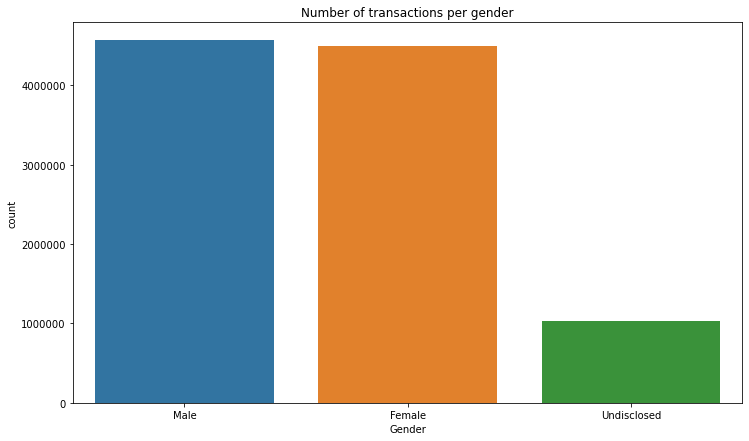

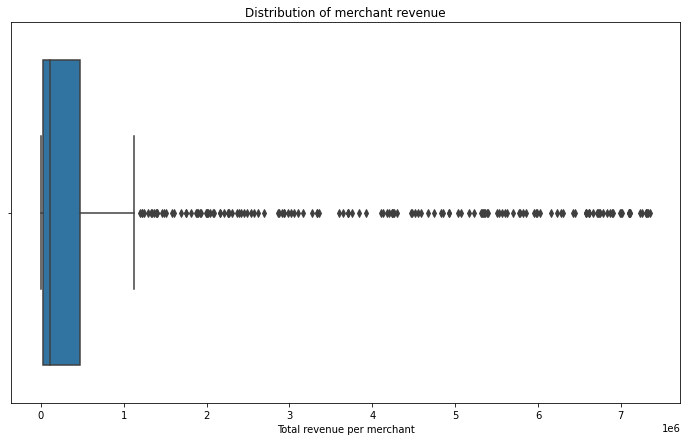

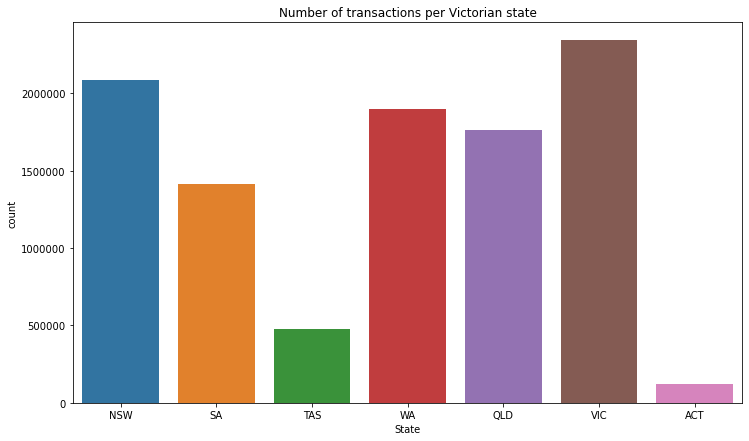

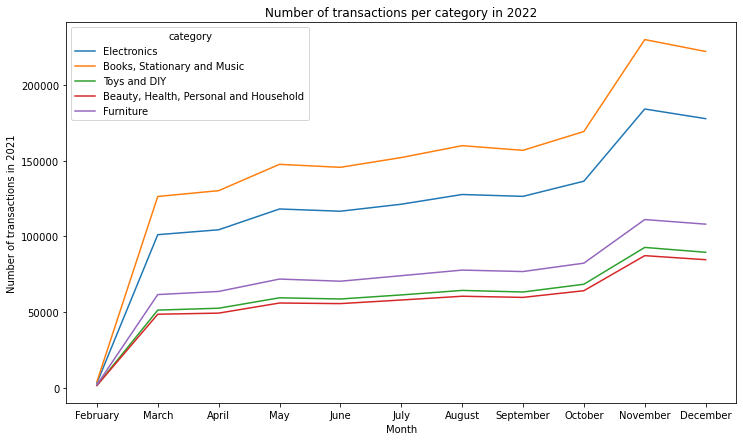

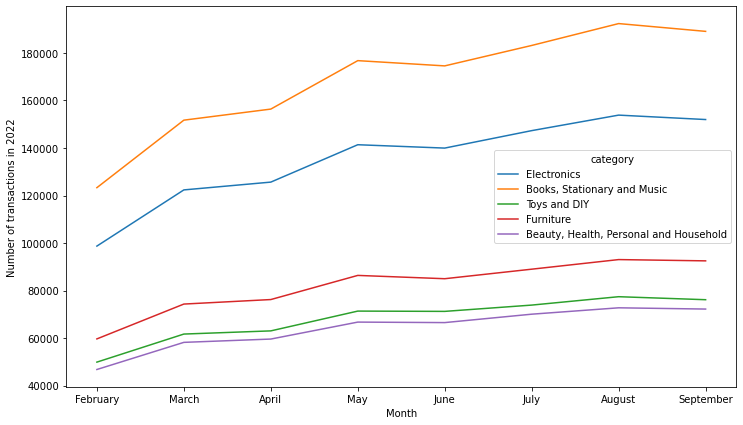

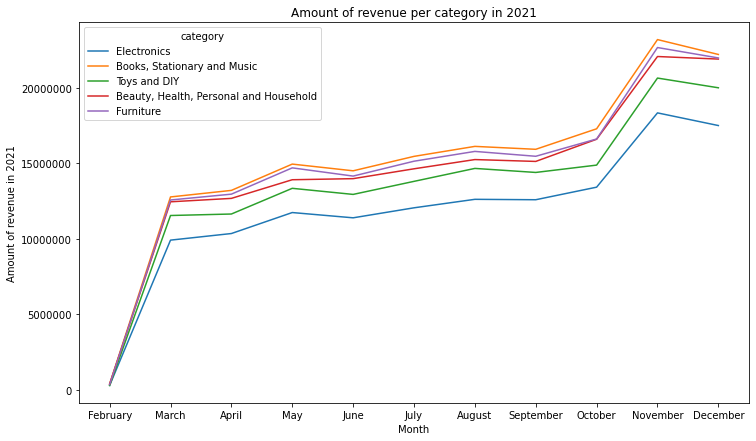

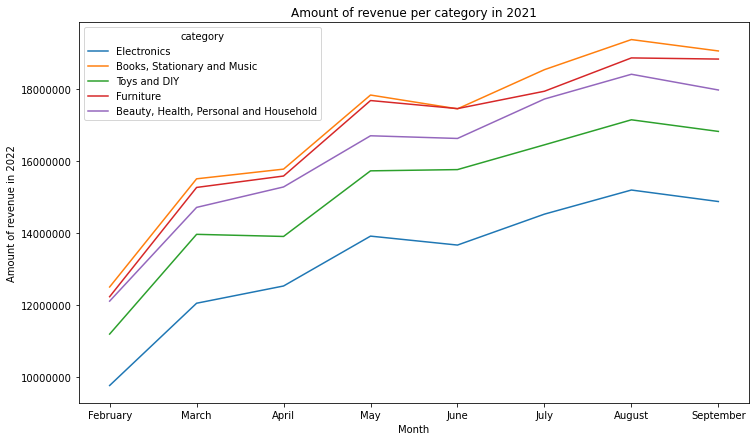

In [16]:
%run "../scripts/visualizations-1.py" '../scripts/paths.json'

### External datasets - Outliers

22/10/08 18:11:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
Summary statistics for the Census data - 


           SA2_code   total_males  total_females  total_persons
count  2.472000e+03   2472.000000    2472.000000    2472.000000
mean   3.177555e+08   5074.887136    5209.415049   10284.254450
std    1.977886e+08   3019.275754    3161.883118    6171.395057
min    1.010210e+08      0.000000       0.000000       0.000000
25%    1.270315e+08   2669.750000    2678.000000    5384.750000
50%    3.030411e+08   4774.000000    4875.000000    9656.000000
75%    4.060111e+08   7169.000000    7511.500000   14675.000000
max    9.999995e+08  14327.000000   13783.000000   28116.000000


Summary statistics for the Income data - 


    SA2_code           SA2_name  income_2018-2019
0  101021007          Braidwood         120763285
1  101021008            Karabar         338308979
2  101021009         Queanbeyan         441160946
3  101021010  

[]


Summary statistics for the Population data - 


    SA2_code                         SA2_name  state_code       state_name  \
0  101021007                        Braidwood           1  New South Wales   
1  101021008                          Karabar           1  New South Wales   
2  101021009                       Queanbeyan           1  New South Wales   
3  101021010                Queanbeyan - East           1  New South Wales   
4  101021012  Queanbeyan West - Jerrabomberra           1  New South Wales   

   population_2020  population_2021  
0             4273             4330  
1             8519             8546  
2            11437            11370  
3             5077             5093  
4            12796            12743  


Summary statistics for the population in 2020 per SA2 code data - 


count     2454.000000
mean     10454.477995
std       6229.349880
min          0.000000
25%       5449.500000
50%       9778.000000
75%      14832.750000
max      28250.000000
Nam

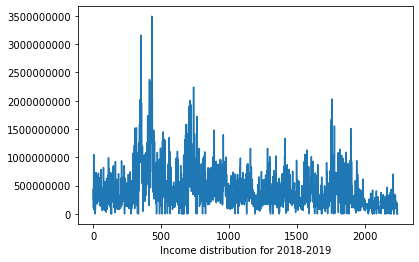

In [17]:
%run "../scripts/outlier_external.py" '../scripts/paths.json'

### Ranking models 

In [18]:
%run "../scripts/BNPL_earning_model.py" '../scripts/paths.json'

22/10/08 18:11:08 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/08 18:11:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:11:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/08 18:11:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/08 18:12:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:12:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/08 18:12:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/08 18:12:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:12:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 18:12:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/08 18:12:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/08 18:12:49 WARN DAGScheduler: Broadcasting large task binary with size 1013.6 KiB


22/10/08 18:12:50 WARN DAGScheduler: Broadcasting large task binary with size 1013.7 KiB


22/10/08 18:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1017.6 KiB


22/10/08 18:12:54 WARN DAGScheduler: Broadcasting large task binary with size 1130.0 KiB


22/10/08 18:12:58 WARN MemoryStore: Not enough space to cache rdd_3086_0 in memory! (computed 124.9 MiB so far)
22/10/08 18:12:58 WARN MemoryStore: Not enough space to cache rdd_3086_6 in memory! (computed 124.9 MiB so far)
22/10/08 18:12:58 WARN MemoryStore: Not enough space to cache rdd_3086_1 in memory! (computed 188.8 MiB so far)
22/10/08 18:12:58 WARN MemoryStore: Not enough space to cache rdd_3086_7 in memory! (computed 188.8 MiB so far)
22/10/08 18:12:58 WARN BlockManager: Persisting block rdd_3086_0 to disk instead.
22/10/08 18:12:58 WARN BlockManager: Persisting block rdd_3086_7 to disk instead.
22/10/08 18:12:58 WARN BlockManager: Persisting block rdd_3086_1 to disk instead.
22/10/08 18:12:58 WARN BlockManager: Persisting block rdd_3086_6 to disk instead.
22/10/08 18:12:58 WARN MemoryStore: Not enough space to cache rdd_3086_5 in memory! (computed 188.8 MiB so far)
22/10/08 18:12:58 WARN BlockManager: Persisting block rdd_3086_5 to disk instead.


22/10/08 18:13:04 WARN DAGScheduler: Broadcasting large task binary with size 1191.7 KiB


22/10/08 18:13:09 WARN DAGScheduler: Broadcasting large task binary with size 1312.7 KiB


22/10/08 18:13:13 WARN DAGScheduler: Broadcasting large task binary with size 1551.7 KiB


22/10/08 18:13:17 WARN DAGScheduler: Broadcasting large task binary with size 2027.9 KiB


22/10/08 18:13:55 WARN DAGScheduler: Broadcasting large task binary with size 1018.9 KiB


22/10/08 18:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1020.0 KiB


22/10/08 18:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1018.9 KiB


22/10/08 18:14:36 WARN DAGScheduler: Broadcasting large task binary with size 1020.0 KiB


In [19]:
# Run all the models to get the features for the ranking model
%run "../scripts/Revenue_model.py" '../scripts/paths.json'

22/10/08 18:15:40 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/08 18:17:11 WARN DAGScheduler: Broadcasting large task binary with size 1015.1 KiB


22/10/08 18:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1015.1 KiB


22/10/08 18:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1019.1 KiB


22/10/08 18:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1131.4 KiB


22/10/08 18:17:18 WARN MemoryStore: Not enough space to cache rdd_3853_6 in memory! (computed 188.8 MiB so far)
22/10/08 18:17:18 WARN MemoryStore: Not enough space to cache rdd_3853_4 in memory! (computed 188.8 MiB so far)
22/10/08 18:17:18 WARN MemoryStore: Not enough space to cache rdd_3853_0 in memory! (computed 188.8 MiB so far)
22/10/08 18:17:18 WARN MemoryStore: Not enough space to cache rdd_3853_3 in memory! (computed 188.8 MiB so far)
22/10/08 18:17:18 WARN MemoryStore: Not enough space to cache rdd_3853_5 in memory! (computed 188.8 MiB so far)
22/10/08 18:17:18 WARN MemoryStore: Not enough space to cache rdd_3853_7 in memory! (computed 188.8 MiB so far)
22/10/08 18:17:18 WARN MemoryStore: Not enough space to cache rdd_3853_2 in memory! (computed 124.9 MiB so far)
22/10/08 18:17:18 WARN BlockManager: Persisting block rdd_3853_5 to disk instead.
22/10/08 18:17:18 WARN BlockManager: Persisting block rdd_3853_7 to disk instead.
22/10/08 18:17:18 WARN BlockManager: Persisting bloc

22/10/08 18:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1193.1 KiB


22/10/08 18:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1314.2 KiB


22/10/08 18:17:38 WARN DAGScheduler: Broadcasting large task binary with size 1547.9 KiB


22/10/08 18:17:42 WARN DAGScheduler: Broadcasting large task binary with size 1992.6 KiB


22/10/08 18:18:19 WARN DAGScheduler: Broadcasting large task binary with size 1020.3 KiB


22/10/08 18:18:21 WARN DAGScheduler: Broadcasting large task binary with size 1021.4 KiB


22/10/08 18:18:50 WARN DAGScheduler: Broadcasting large task binary with size 1020.3 KiB


22/10/08 18:18:52 WARN DAGScheduler: Broadcasting large task binary with size 1021.4 KiB


In [20]:
%run "../scripts/Customers_model.py" '../scripts/paths.json'

22/10/08 18:19:45 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/08 18:21:20 WARN DAGScheduler: Broadcasting large task binary with size 1026.7 KiB


22/10/08 18:21:21 WARN DAGScheduler: Broadcasting large task binary with size 1026.7 KiB


22/10/08 18:21:23 WARN DAGScheduler: Broadcasting large task binary with size 1030.7 KiB


22/10/08 18:21:25 WARN DAGScheduler: Broadcasting large task binary with size 1143.0 KiB


22/10/08 18:21:27 WARN MemoryStore: Not enough space to cache rdd_4629_7 in memory! (computed 188.8 MiB so far)
22/10/08 18:21:27 WARN BlockManager: Persisting block rdd_4629_7 to disk instead.
22/10/08 18:21:27 WARN MemoryStore: Not enough space to cache rdd_4629_5 in memory! (computed 188.8 MiB so far)
22/10/08 18:21:27 WARN BlockManager: Persisting block rdd_4629_5 to disk instead.
22/10/08 18:21:27 WARN MemoryStore: Not enough space to cache rdd_4629_3 in memory! (computed 188.8 MiB so far)
22/10/08 18:21:27 WARN BlockManager: Persisting block rdd_4629_3 to disk instead.
22/10/08 18:21:27 WARN MemoryStore: Not enough space to cache rdd_4629_0 in memory! (computed 188.8 MiB so far)
22/10/08 18:21:27 WARN BlockManager: Persisting block rdd_4629_0 to disk instead.
22/10/08 18:21:27 WARN MemoryStore: Not enough space to cache rdd_4629_4 in memory! (computed 188.8 MiB so far)
22/10/08 18:21:27 WARN BlockManager: Persisting block rdd_4629_4 to disk instead.
22/10/08 18:21:27 WARN MemoryS

22/10/08 18:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1204.2 KiB


22/10/08 18:21:33 WARN MemoryStore: Not enough space to cache rdd_4629_6 in memory! (computed 188.8 MiB so far)


22/10/08 18:21:36 WARN DAGScheduler: Broadcasting large task binary with size 1325.2 KiB


22/10/08 18:21:40 WARN DAGScheduler: Broadcasting large task binary with size 1567.0 KiB


22/10/08 18:21:43 WARN DAGScheduler: Broadcasting large task binary with size 2045.1 KiB


22/10/08 18:22:21 WARN DAGScheduler: Broadcasting large task binary with size 1031.9 KiB


22/10/08 18:22:23 WARN DAGScheduler: Broadcasting large task binary with size 1033.0 KiB


22/10/08 18:22:58 WARN DAGScheduler: Broadcasting large task binary with size 1031.9 KiB


22/10/08 18:22:59 WARN DAGScheduler: Broadcasting large task binary with size 1033.0 KiB


In [21]:
%run "../scripts/Transactions_model.py" 

22/10/08 18:23:53 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [22]:
%run "../scripts/fraud_feature.py" '../scripts/paths.json'

22/10/08 18:24:11 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [23]:
# take list of values as weights for fraud, transactions, revenue, customer, take rate
%run '../scripts/ranking_model.py' 4,2,1,3,5

Ranking for  Furniture category: 
Number of merchants in this category:  261
Rank  1 :  Erat Vitae LLP
Rank  2 :  Lorem Ipsum Sodales Industries
Rank  3 :  Interdum Feugiat Sed Inc.
Rank  4 :  Eget Laoreet Posuere PC
Rank  5 :  Phasellus At Limited
Rank  6 :  Libero Et Limited
Rank  7 :  Auctor Company
Rank  8 :  Ornare Limited
Rank  9 :  Purus Gravida Sagittis Ltd
Rank  10 :  Phasellus Dapibus Incorporated


Ranking for  Electronics category: 
Number of merchants in this category:  317
Rank  1 :  Lacus Consulting
Rank  2 :  Ipsum Dolor Sit Corporation
Rank  3 :  Placerat Eget Venenatis Limited
Rank  4 :  Mauris Non Institute
Rank  5 :  Phasellus At Company
Rank  6 :  Dictum Phasellus In Institute
Rank  7 :  Ultricies Dignissim LLP
Rank  8 :  Orci In Consequat Corporation
Rank  9 :  Ornare Fusce Inc.
Rank  10 :  Faucibus Leo Ltd


Ranking for  Toys and DIY category: 
Number of merchants in this category:  196
Rank  1 :  Leo In Consulting
Rank  2 :  Vehicula Pellentesque Corporation
Ran

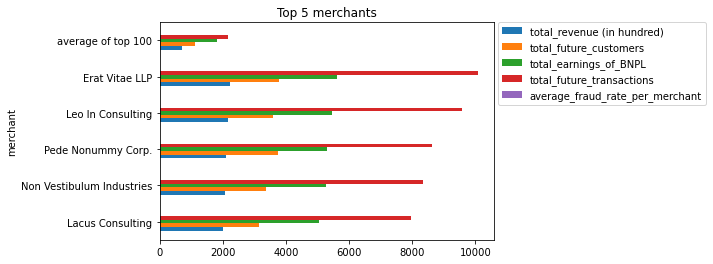

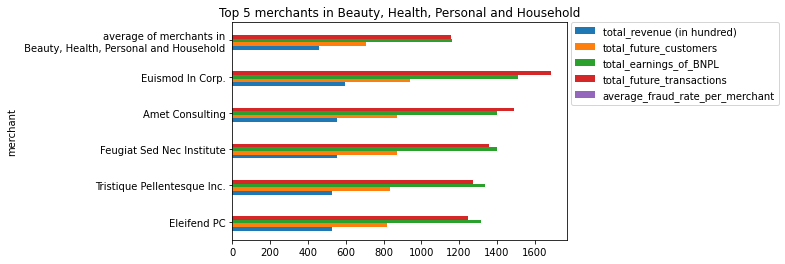

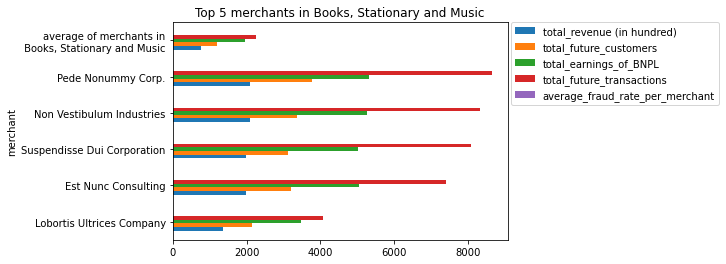

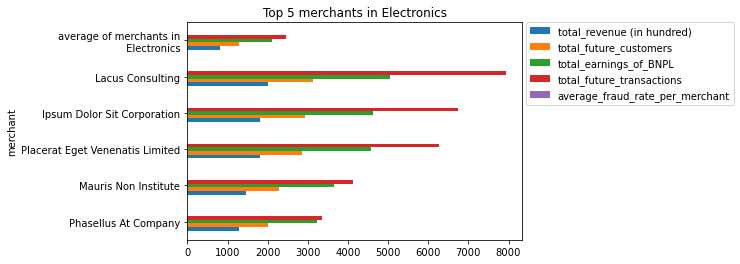

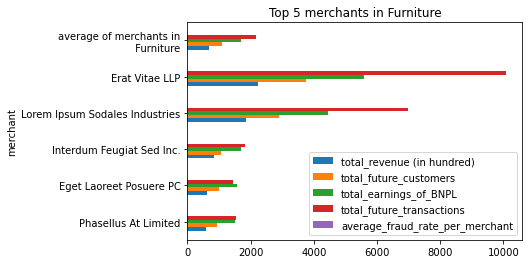

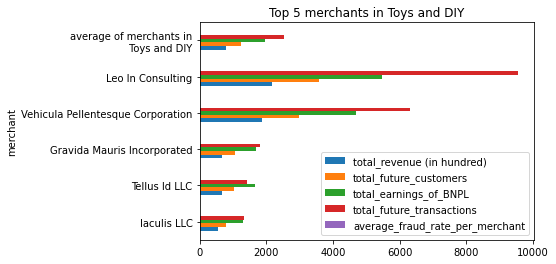

In [2]:
%run "../scripts/rank_visualisation.py" 

In [28]:
final_rank.head()

,merchant_name,merchant_abn,category,total_future_transactions,total_future_customers,total_revenue,Unnamed: 0,total_earnings_of_BNPL,average_fraud_rate_per_merchant,ranking_feature
0,Erat Vitae LLP,24852446429,Furniture,11200.278322,3575.0,243807.029935,526,7440.203022,0.0,10.970937
1,Leo In Consulting,86578477987,Toys and DIY,10262.278322,3458.0,251096.092656,287,7263.332548,0.0,10.615569
2,Pede Nonummy Corp.,64203420245,"Books, Stationary and Music",10066.278322,3389.0,243808.485144,133,7049.535139,0.0,10.349779
3,Non Vestibulum Industries,49891706470,"Books, Stationary and Music",9606.278322,3360.0,241719.855504,412,6988.709834,0.0,10.194199
4,Lacus Consulting,45629217853,Electronics,8850.278322,3187.0,231601.949486,328,6705.354485,0.0,9.683169
